In [1]:
import time
import toml
import torch as np
from torchvision.utils import save_image
from torch.utils import data

from tools.celeba import CelebALoader
from dataset import Split

from models.models import create_model
from tools.toml import load_option
from tools.mask import mask_iter

## 数据载入

In [2]:
header_opt = load_option('options/header.toml')
loader = CelebALoader(header_opt.data_root)
dataset = Split(loader, header_opt.fine_size)
train_data = dataset.train('bbox', pil_transform=True, alpha=0.5)
trainset = data.DataLoader(train_data,
                           batch_size=header_opt.batch_size,
                           shuffle=True)
maskset = mask_iter(header_opt.mask_root, header_opt.fine_size)
print('训练集数量：', len(trainset))
print('掩码数量：', len(maskset))

训练集数量： 162770
掩码数量： 12000


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


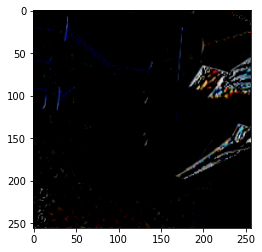

In [3]:
train_data = dataset.train('bbox', pil_transform=True, alpha=0.5)
x = train_data[7][0].transpose(0, 2)

from matplotlib import pyplot as plt
# 查看处理后的图片
plt.imshow(x);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


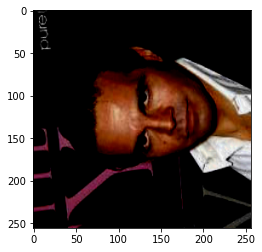

In [4]:
train_data = dataset.train('bbox', pil_transform=True, alpha=0.95)
x = train_data[7][0].transpose(0, 2)

from matplotlib import pyplot as plt
# 查看处理后的图片
plt.imshow(x);

## 模型载入

In [5]:
def mask_op(mask):
    mask = mask.cuda()
    mask = mask[0][0]
    mask = np.unsqueeze(mask, 0)
    mask = np.unsqueeze(mask, 1)
    mask = mask.byte()
    return mask

In [6]:
model_opt = load_option('options/train2.toml')
model = create_model(model_opt)

csa_net
initialize network with normal
initialize network with normal
initialize network with normal
initialize network with normal
---------- Networks initialized -------------
UnetGeneratorCSA(
  (model): UnetSkipConnectionBlock_3(
    (model): Sequential(
      (0): Conv2d(6, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): UnetSkipConnectionBlock_3(
        (model): Sequential(
          (0): LeakyReLU(negative_slope=0.2, inplace=True)
          (1): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), dilation=(2, 2))
          (2): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (3): LeakyReLU(negative_slope=0.2, inplace=True)
          (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (5): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (6): UnetSkipConnectionBlock_3(
            (model): Sequential(
              (0): LeakyRe

In [7]:
from random import randint

In [9]:
opt = load_option('options/train3.toml')

total_steps = 0
iter_start_time = time.time()
# 载入已经训练的模型
load_epoch = -1
if load_epoch >= 0:
    model.load(load_epoch)
start_epoch = load_epoch + 1
for epoch in range(start_epoch, opt.epochs):
    epoch_start_time = time.time()
    epoch_iter = 0
    alpha = randint(0, 100)/100
    train_data = dataset.train('bbox', pil_transform=True, alpha=alpha)
    trainset = data.DataLoader(train_data,
                               batch_size=opt.batch_size,
                               shuffle=True)
    for batch, mask in zip(trainset, maskset):
        image = batch[0]
        mask = mask_op(mask)
        total_steps += header_opt.batch_size
        epoch_iter += header_opt.batch_size
        # it not only sets the input data with mask, but also sets the latent mask.
        model.set_input(image, mask)
        model.set_gt_latent()
        model.optimize_parameters()
        if total_steps % opt.display_freq == 0:
            real_A, real_B, fake_B = model.get_current_visuals()
            # real_A=input, real_B=ground truth fake_b=output
            pic = (np.cat([real_A, real_B, fake_B], dim=0) + 1) / 2.0
            save_image_path = f"{opt.save_dir}/epoch{epoch}-{total_steps}-alpha{alpha}.jpg"
            save_image(pic, save_image_path, nrow=3)
        if total_steps % 100 == 0:
            errors = model.get_current_errors()
            t = (time.time() - iter_start_time) / opt.batch_size
            print(f"Epoch/total_steps/alpha: {epoch}/{total_steps}/{alpha}", dict(errors))
    if epoch % opt.save_epoch_freq == 0:
        print(f'保存模型 Epoch {epoch}, iters {total_steps} 在 {opt.save_dir}')
        model.save(f'{epoch}-{alpha}')
    print(f'Epoch/Epochs {epoch}/{opt.epochs-1} 花费时间：{time.time() - epoch_start_time}s')
    model.update_learning_rate()

Epoch/total_steps/alpha: 0/100/0.54 {'G_GAN': 6.9527411460876465, 'G_L1': 19.21937370300293, 'D': 0.5837659239768982, 'F': 0.09569887816905975}
Epoch/total_steps/alpha: 0/200/0.54 {'G_GAN': 6.976653099060059, 'G_L1': 17.535900115966797, 'D': 0.3354734778404236, 'F': 0.053377240896224976}
Epoch/total_steps/alpha: 0/300/0.54 {'G_GAN': 6.647252082824707, 'G_L1': 17.34543228149414, 'D': 0.49625569581985474, 'F': 0.0427241213619709}
Epoch/total_steps/alpha: 0/400/0.54 {'G_GAN': 5.171706199645996, 'G_L1': 13.297514915466309, 'D': 1.3639895915985107, 'F': 0.04206874966621399}
Epoch/total_steps/alpha: 0/500/0.54 {'G_GAN': 6.983954429626465, 'G_L1': 13.967815399169922, 'D': 0.3999024033546448, 'F': 0.031710848212242126}
Epoch/total_steps/alpha: 0/600/0.54 {'G_GAN': 6.054523468017578, 'G_L1': 13.622611999511719, 'D': 0.7401635646820068, 'F': 0.02517031319439411}
Epoch/total_steps/alpha: 0/700/0.54 {'G_GAN': 5.8607869148254395, 'G_L1': 13.965970039367676, 'D': 1.0379140377044678, 'F': 0.018163762

Epoch/total_steps/alpha: 0/5800/0.54 {'G_GAN': 6.519583702087402, 'G_L1': 10.041399955749512, 'D': 0.35131406784057617, 'F': 0.009917130693793297}
Epoch/total_steps/alpha: 0/5900/0.54 {'G_GAN': 7.197571754455566, 'G_L1': 10.347099304199219, 'D': 0.18228867650032043, 'F': 0.00702451728284359}
Epoch/total_steps/alpha: 0/6000/0.54 {'G_GAN': 5.679784297943115, 'G_L1': 7.0281147956848145, 'D': 0.7465766668319702, 'F': 0.007315279915928841}
Epoch/total_steps/alpha: 0/6100/0.54 {'G_GAN': 6.600762367248535, 'G_L1': 10.2357816696167, 'D': 0.3136906921863556, 'F': 0.005101576913148165}
Epoch/total_steps/alpha: 0/6200/0.54 {'G_GAN': 8.486144065856934, 'G_L1': 12.869037628173828, 'D': 0.26628077030181885, 'F': 0.004048660397529602}
Epoch/total_steps/alpha: 0/6300/0.54 {'G_GAN': 7.161832809448242, 'G_L1': 12.319828987121582, 'D': 0.20243248343467712, 'F': 0.007583685219287872}
Epoch/total_steps/alpha: 0/6400/0.54 {'G_GAN': 5.959709167480469, 'G_L1': 9.192459106445312, 'D': 0.6419399976730347, 'F': 

Epoch/total_steps/alpha: 0/11500/0.54 {'G_GAN': 7.049068450927734, 'G_L1': 10.585933685302734, 'D': 0.15986695885658264, 'F': 0.0030021527782082558}
Epoch/total_steps/alpha: 0/11600/0.54 {'G_GAN': 6.392288684844971, 'G_L1': 8.0428466796875, 'D': 0.440293550491333, 'F': 0.0072971535846591}
Epoch/total_steps/alpha: 0/11700/0.54 {'G_GAN': 6.692526817321777, 'G_L1': 6.606377124786377, 'D': 0.3228653073310852, 'F': 0.004225699231028557}
Epoch/total_steps/alpha: 0/11800/0.54 {'G_GAN': 7.6527557373046875, 'G_L1': 10.679791450500488, 'D': 0.09253951907157898, 'F': 0.0032982584089040756}
Epoch/total_steps/alpha: 0/11900/0.54 {'G_GAN': 8.06454849243164, 'G_L1': 10.423736572265625, 'D': 0.12127120792865753, 'F': 0.0034316403325647116}
Epoch/total_steps/alpha: 0/12000/0.54 {'G_GAN': 6.019932270050049, 'G_L1': 6.629371643066406, 'D': 0.7132800817489624, 'F': 0.03869121894240379}
保存模型 Epoch 0, iters 12000 在 ../new-outputs
Epoch/Epochs 0/9 花费时间：21134.11440706253s
learning rate = 0.0002000
Epoch/total

Epoch/total_steps/alpha: 1/17100/0.9 {'G_GAN': 5.305302619934082, 'G_L1': 9.946383476257324, 'D': 1.0108259916305542, 'F': 0.008443831466138363}
Epoch/total_steps/alpha: 1/17200/0.9 {'G_GAN': 6.477107524871826, 'G_L1': 12.602678298950195, 'D': 0.3252362608909607, 'F': 0.005173578392714262}
Epoch/total_steps/alpha: 1/17300/0.9 {'G_GAN': 6.751703262329102, 'G_L1': 11.744325637817383, 'D': 0.28337955474853516, 'F': 0.008896063081920147}
Epoch/total_steps/alpha: 1/17400/0.9 {'G_GAN': 4.984255790710449, 'G_L1': 7.142381191253662, 'D': 1.2510327100753784, 'F': 0.0031674569472670555}
Epoch/total_steps/alpha: 1/17500/0.9 {'G_GAN': 6.0121169090271, 'G_L1': 9.20836067199707, 'D': 0.5976420640945435, 'F': 0.0023215184919536114}
Epoch/total_steps/alpha: 1/17600/0.9 {'G_GAN': 5.72856330871582, 'G_L1': 7.8331618309021, 'D': 0.643161416053772, 'F': 0.0035907847341150045}
Epoch/total_steps/alpha: 1/17700/0.9 {'G_GAN': 5.726478576660156, 'G_L1': 6.538680076599121, 'D': 0.7870430946350098, 'F': 0.006094

Epoch/total_steps/alpha: 1/22800/0.9 {'G_GAN': 6.476362228393555, 'G_L1': 12.36387825012207, 'D': 0.4299798011779785, 'F': 0.004339261911809444}
Epoch/total_steps/alpha: 1/22900/0.9 {'G_GAN': 6.096968650817871, 'G_L1': 8.300575256347656, 'D': 0.49026477336883545, 'F': 0.007504766806960106}
Epoch/total_steps/alpha: 1/23000/0.9 {'G_GAN': 5.320246696472168, 'G_L1': 9.070494651794434, 'D': 1.8210513591766357, 'F': 0.004028326366096735}
Epoch/total_steps/alpha: 1/23100/0.9 {'G_GAN': 6.273982524871826, 'G_L1': 10.158495903015137, 'D': 0.6160917282104492, 'F': 0.01303262822329998}
Epoch/total_steps/alpha: 1/23200/0.9 {'G_GAN': 6.4520463943481445, 'G_L1': 7.484485149383545, 'D': 0.3031673729419708, 'F': 0.006192847155034542}
Epoch/total_steps/alpha: 1/23300/0.9 {'G_GAN': 6.317741394042969, 'G_L1': 10.26031494140625, 'D': 0.6868776082992554, 'F': 0.007277307566255331}
Epoch/total_steps/alpha: 1/23400/0.9 {'G_GAN': 7.17411994934082, 'G_L1': 8.416385650634766, 'D': 0.16074645519256592, 'F': 0.009

Epoch/total_steps/alpha: 2/28400/0.41 {'G_GAN': 7.032535076141357, 'G_L1': 7.431457996368408, 'D': 0.18466386198997498, 'F': 0.005050342064350843}
Epoch/total_steps/alpha: 2/28500/0.41 {'G_GAN': 8.452445030212402, 'G_L1': 7.828023910522461, 'D': 0.13431981205940247, 'F': 0.003877944080159068}
Epoch/total_steps/alpha: 2/28600/0.41 {'G_GAN': 5.533794403076172, 'G_L1': 3.7283313274383545, 'D': 0.933695912361145, 'F': 0.011521175503730774}
Epoch/total_steps/alpha: 2/28700/0.41 {'G_GAN': 7.859960556030273, 'G_L1': 7.570947647094727, 'D': 0.06074835732579231, 'F': 0.012728012166917324}
Epoch/total_steps/alpha: 2/28800/0.41 {'G_GAN': 7.182123184204102, 'G_L1': 9.212873458862305, 'D': 0.22242406010627747, 'F': 0.0036676935851573944}
Epoch/total_steps/alpha: 2/28900/0.41 {'G_GAN': 6.053994655609131, 'G_L1': 4.983006954193115, 'D': 0.6358355283737183, 'F': 0.02268243208527565}
Epoch/total_steps/alpha: 2/29000/0.41 {'G_GAN': 5.8845295906066895, 'G_L1': 6.084632873535156, 'D': 0.8436021208763123, 

Epoch/total_steps/alpha: 2/34000/0.41 {'G_GAN': 7.176141738891602, 'G_L1': 8.450908660888672, 'D': 0.18000856041908264, 'F': 0.0052593545988202095}
Epoch/total_steps/alpha: 2/34100/0.41 {'G_GAN': 6.362202167510986, 'G_L1': 7.979827880859375, 'D': 0.565955638885498, 'F': 0.00492497393861413}
Epoch/total_steps/alpha: 2/34200/0.41 {'G_GAN': 6.634654998779297, 'G_L1': 6.0614800453186035, 'D': 0.3150818347930908, 'F': 0.009788675233721733}
Epoch/total_steps/alpha: 2/34300/0.41 {'G_GAN': 5.8045454025268555, 'G_L1': 4.982624053955078, 'D': 0.8621699810028076, 'F': 0.03827831149101257}
Epoch/total_steps/alpha: 2/34400/0.41 {'G_GAN': 7.503863334655762, 'G_L1': 9.90261173248291, 'D': 0.10173036903142929, 'F': 0.007501407526433468}
Epoch/total_steps/alpha: 2/34500/0.41 {'G_GAN': 6.051119804382324, 'G_L1': 4.4866485595703125, 'D': 0.5410259366035461, 'F': 0.019913556054234505}
Epoch/total_steps/alpha: 2/34600/0.41 {'G_GAN': 8.56782341003418, 'G_L1': 7.6122612953186035, 'D': 0.2550266683101654, 'F'

Epoch/total_steps/alpha: 3/39600/0.29 {'G_GAN': 4.937910079956055, 'G_L1': 4.24731969833374, 'D': 1.355950951576233, 'F': 0.009883560240268707}
Epoch/total_steps/alpha: 3/39700/0.29 {'G_GAN': 5.630132675170898, 'G_L1': 5.218460559844971, 'D': 0.7670831084251404, 'F': 0.0045027113519608974}
Epoch/total_steps/alpha: 3/39800/0.29 {'G_GAN': 5.338877201080322, 'G_L1': 4.328843116760254, 'D': 0.9559003114700317, 'F': 0.005799833685159683}
Epoch/total_steps/alpha: 3/39900/0.29 {'G_GAN': 6.66453218460083, 'G_L1': 6.974527359008789, 'D': 0.2860182523727417, 'F': 0.009067229926586151}
Epoch/total_steps/alpha: 3/40000/0.29 {'G_GAN': 5.259439468383789, 'G_L1': 3.7247114181518555, 'D': 0.9868277907371521, 'F': 0.0051784394308924675}
Epoch/total_steps/alpha: 3/40100/0.29 {'G_GAN': 7.5864176750183105, 'G_L1': 4.85674524307251, 'D': 0.0788838341832161, 'F': 0.004699477925896645}
Epoch/total_steps/alpha: 3/40200/0.29 {'G_GAN': 6.953179359436035, 'G_L1': 11.48771858215332, 'D': 0.34375715255737305, 'F':

KeyboardInterrupt: 